# CNNが学習した内容を可視化する

In [1]:
# My Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 中間層の出力を可視化

In [0]:
import os
os.chdir('drive/My Drive/機械学習')

In [3]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

単一の画像を前処理

In [4]:
img_path = 'cats_and_dogs_small/test/cats/cat.1700.jpg'

# この画像を4次元テンソルとして前処理
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# このモデルの訓練に使用された入力が次の方法で前処理されていることに注意
img_tensor /= 255.

# 形状は(1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


テスト画像を表示

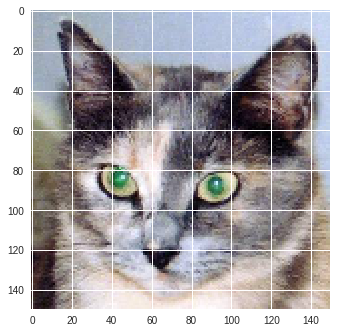

In [5]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [0]:
from keras import models

# 出力側の8つの層から出力を抽出
layer_outputs = [layer.output for layer in model.layers[:8]]

# 特定の層をもとに、これから出力を返すモデルを作成
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

モデルを予測モードで実行

In [0]:
# 5つのNumPy配列（層の活性化ごとに1つ）のリストを返す
activations = activation_model.predict(img_tensor)

In [8]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


3番目のチャンネルを可視化

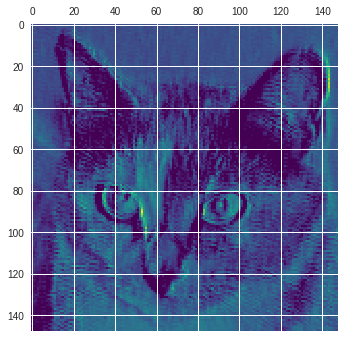

In [9]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

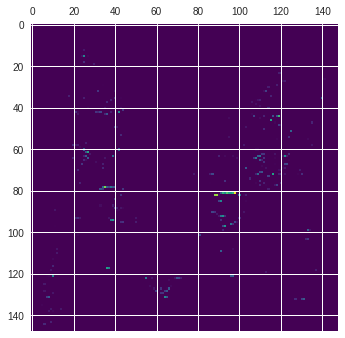

In [10]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

中間層の活性化ごとに全てのチャンネルを可視化

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


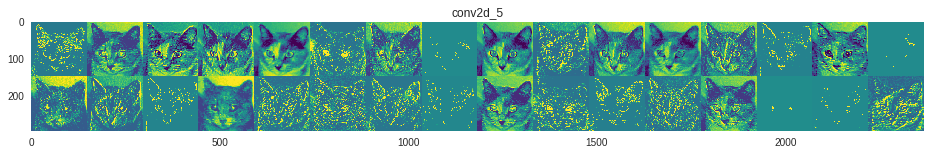

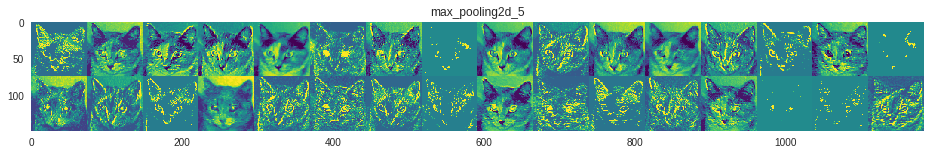

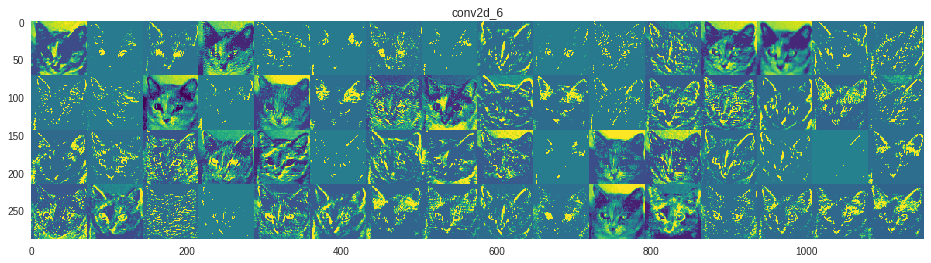

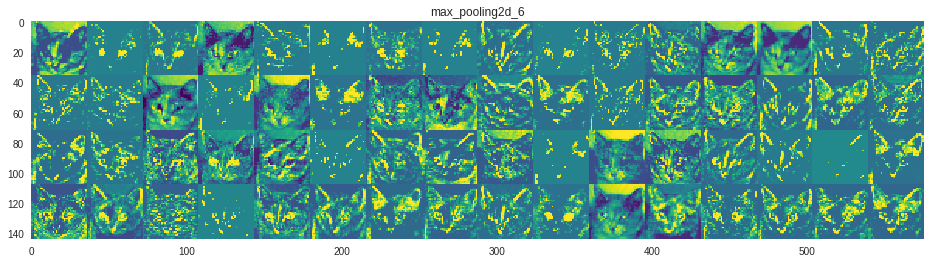

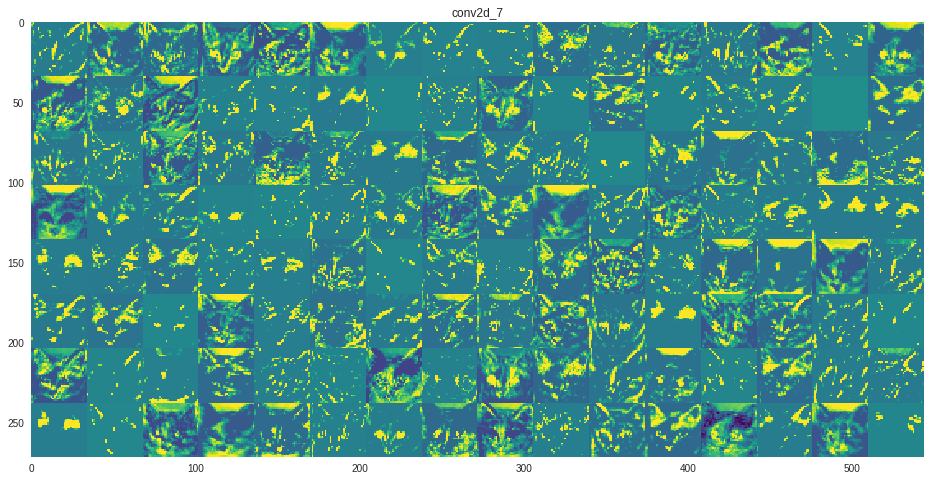

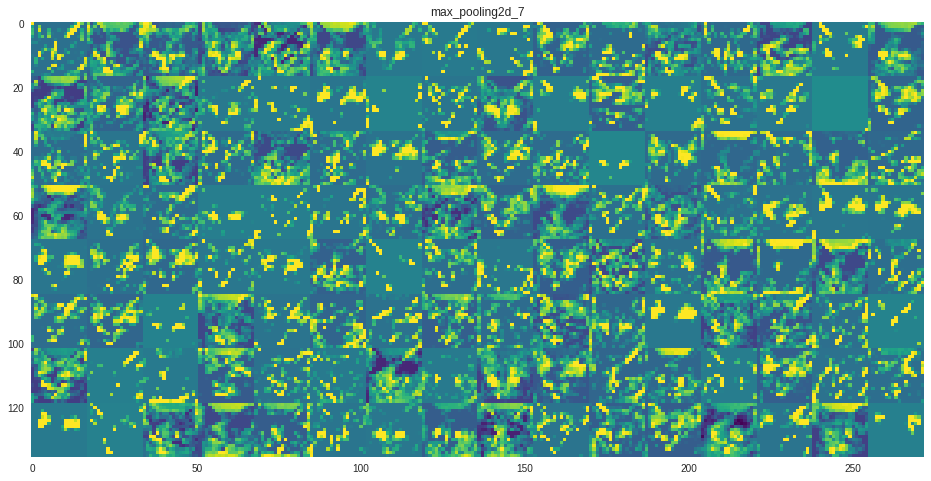

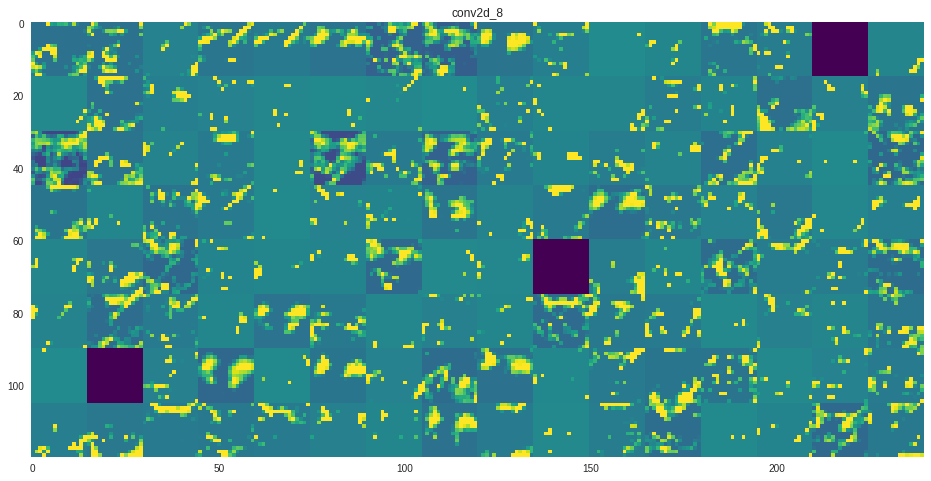

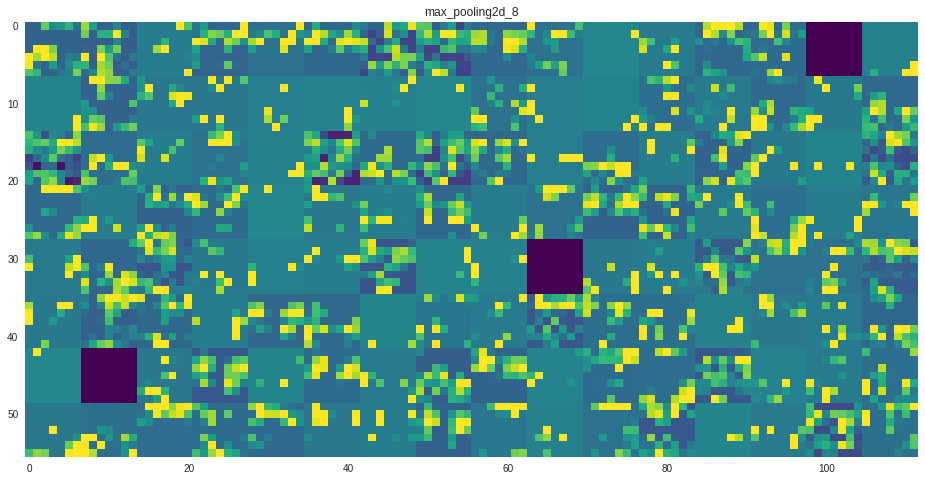

In [11]:
# プロットの一部として使用する層の名前
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)
  
images_per_row = 16

# 特徴マップを表示
for layer_name, layer_activation in zip(layer_names,  activations):
  # 特徴マップに含まれている特徴の数
  n_features = layer_activation.shape[-1]
  
  # 特徴マップの形状(1, size, size, n_features)
  size = layer_activation.shape[1]
  
  # この行列で活性化チャンネルをタイル表示
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  
  # 各フィルタを一つの大きな水平グリッドでタイル表示
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      # 特徴量の見た目をを良くするための後処理
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
      
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')
  
plt.show()

# CNNのフィルタを可視化する

フィルタを可視化するための損失テンソルの定義

In [12]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

58892288/58889256 [==============================] - 6s 0us/step


入力に関する損失関数の勾配を取得

In [0]:
# gradientsの呼び出しはテンソル（この場合はサイズ1）のリストを返す
# このため、最初の要素（テンソル）だけを保持する
grads = K.gradients(loss, model.input)[0]

勾配の正則化

In [0]:
# 除算の前に1e-5を足すことで、0による除算を回避
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

入力値をNumpy配列で受け取り、出力値をNumpy配列で返す関数

In [0]:
iterate = K.function([model.input], [loss, grads])

# 早速テストしてみる
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

確率的勾配降下法を使って損失値を最大化

In [0]:
# 最初はノイズが含まれたグレースケール画像を使用
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# 勾配上昇法を40ステップ実行
step = 1.
for i in range(40):
  # 損失値と勾配値を計算
  loss_value, grads_value = iterate([input_img_data])
  # 損失が最大になる方向に入力画像を調整
  input_img_data += grads_value * step

テンソルを有効な画像に変換するユーティリティ関数

In [0]:
def deprocess_image(x):
  
  # テンソルを正規化：中心を0、標準偏差を0.1にする
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  
  # [0.1]でクリッピング
  x += 0.5
  x = np.clip(x, 0, 1)
  
  # RGB配列に変換
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

フィルタを可視化するための関数

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
  # ターゲット層のn番目のフィルタの活性化を最大化する損失関数を構築
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])
  
  # この損失関数を使って入力画像の勾配を計算
  grads = K.gradients(loss, model.input)[0]
  
  #正則化トリック：勾配を正則化
  grads /= (K.sqrt(K.square(grads)) + 1e-5)
  
  # 入力画像に基づいて損失値と勾配を返す関数
  iterate = K.function([model.input], [loss, grads])
  
  # 最初はノイズが含まれたグレースケール画像を使用
  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
  
  # 勾配上昇法を40ステップ実行
  step = 1.
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    
  img = input_img_data[0]
  return deprocess_image(img)

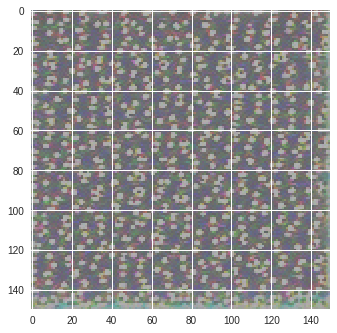

In [19]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

層の各フィルタの応答パターンで構成されたグリッドの生成

In [20]:
layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']
for layer_name in layers:
  size = 64
  margin = 5
  
  # 結果を格納する空（黒）の画像
  results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
  
  for i in range(8): # resultsグリッドの行を順番に処理
    for j in range(8): # resultsグリッドの列を順に処理
      # layer_nameのフィルタi + (j * 8)のパターンを生成
      filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
      
      # resultsグリッドの矩形(i, j)に結果を配置
      horizontal_start = i * size + i * margin
      horizontal_end = horizontal_start + size
      vertical_start = j * size + j * margin
      vertical_end = vertical_start + size
      results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
      
  # resultsグリッドを表示
  plt.figure(figsize=(20, 20))
  plt.imshow(results)
  plt.show()